# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
! conda list | grep mysql-connector-python

mysql-connector-python    8.4.0           py312h86e49da_1    anaconda


In [2]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [23]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [4]:
cursor = con.cursor()

sql = """
select 
max(hire_date),
min(hire_date)
from employees
"""

cursor.execute(sql)
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [ ]:
import pandas as pd

In [24]:
cursor = con.cursor() 

sql= """SELECT 
    sal.emp_no, sal.salary, sal.from_date, sal.to_date
FROM
    salaries AS sal
        JOIN
    (SELECT 
        emp_no, MAX(to_date) AS max_date
    FROM
        salaries
    GROUP BY emp_no) AS mdate ON sal.emp_no = mdate.emp_no
        AND sal.to_date = mdate.max_date"""

cursor.execute(sql)

In [25]:
field_names = [i[0] for i in cursor.description]
res = pd.DataFrame(cursor.fetchall(), columns = field_names)

In [33]:
print(res.columns)
print(res.shape)
res.head(3)

Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')
(300180, 4)


,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [37]:
res.dtypes

emp_no        int64
salary        int64
from_date    object
to_date      object
dtype: object

Як бачимо тип колонки to_date - object - тобто може зберігати будь - які обьекти Python. Віведемо окремий екзкмпляр і бачимо що це  datetime.date

In [45]:
print(type(res['to_date'].iloc[0]))

<class 'datetime.date'>


In [48]:
from datetime import date

comparison_date = date(9999, 1, 1)
count_equal = (res['to_date'] == comparison_date).sum()
count_no_equal = (res['to_date'] != comparison_date).sum()
print(f"Кількість значень, рівних '9999-01-01': {count_equal}")
print(f"Кількість значень, не рівних '9999-01-01': {count_no_equal}")

Кількість значень, рівних '9999-01-01': 240124
Кількість значень, не рівних '9999-01-01': 60056


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

In [53]:
working_emp = res[res['to_date'] == comparison_date]
working_emp.shape

(240124, 4)

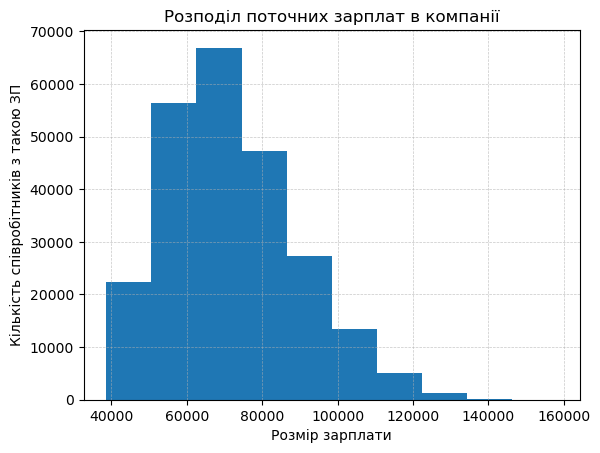

In [57]:
import matplotlib.pyplot as plt
plt.hist(working_emp['salary'], bins=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.title('Розподіл поточних зарплат в компанії')
plt.xlabel('Розмір зарплати')
plt.ylabel('Кількість співробітників з такою ЗП')
plt.show()

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [58]:
con.close()